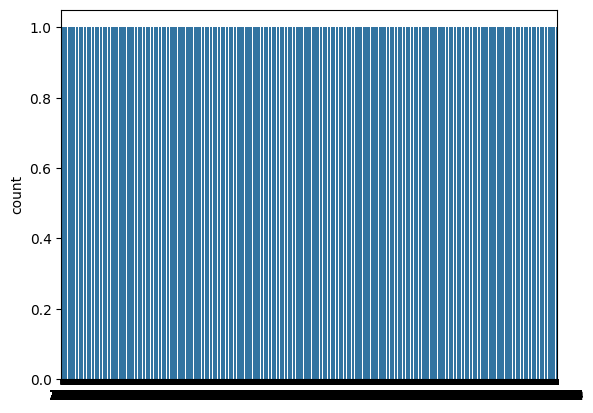

Numeric Columns: 
Index(['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps', 'label'],
      dtype='object') 

Object Columns: 
Index(['src', 'dst', 'protocol'], dtype='object') 

Number of Numeric Features:  20
Number of Object Features:  3
dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
pairflow         0
protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64
[0 1]
Index(['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins'

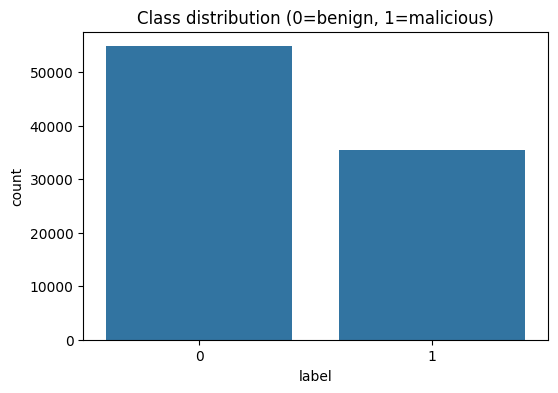

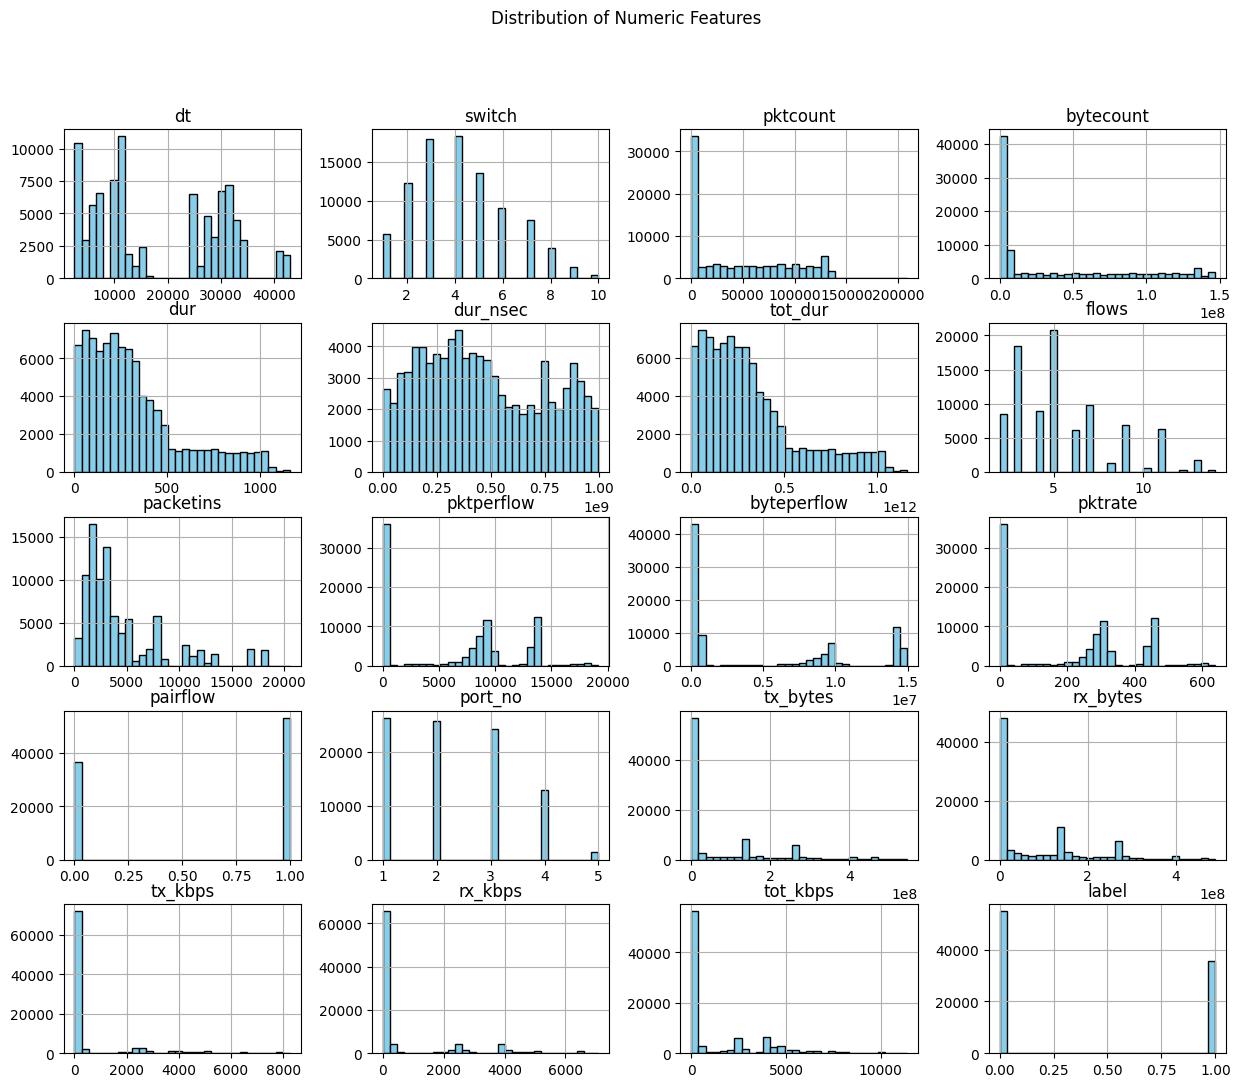

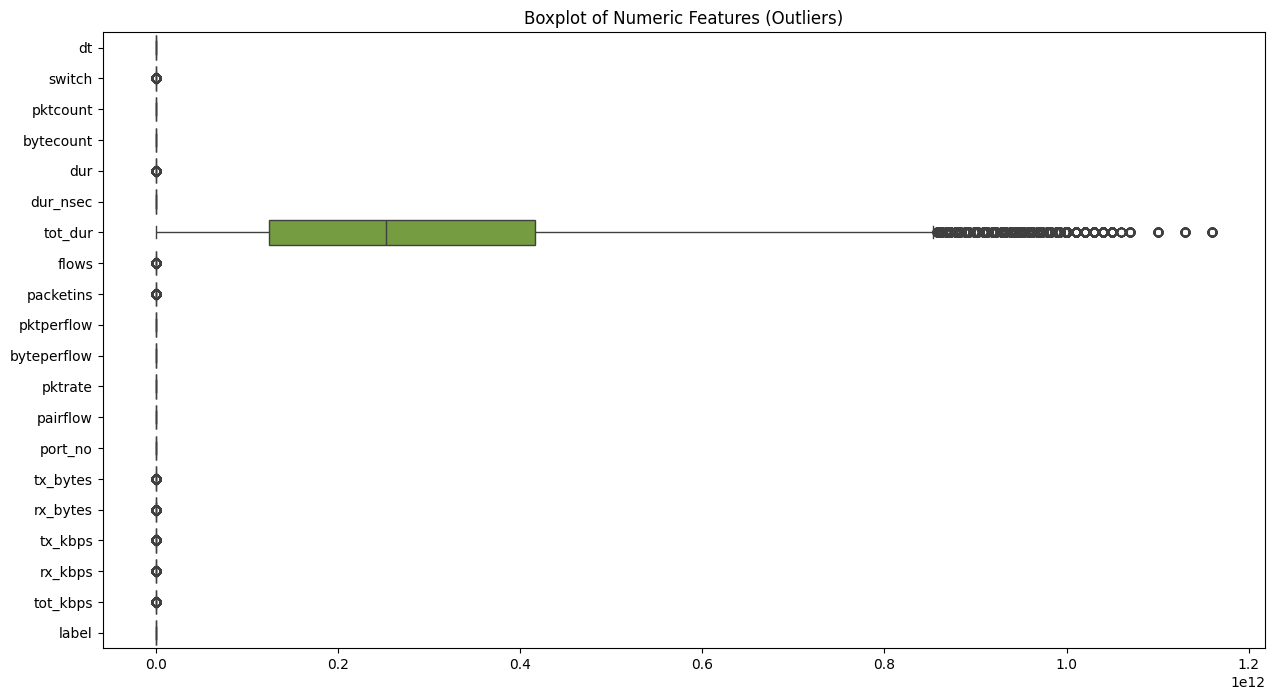

NameError: name 'protocol_mapping' is not defined

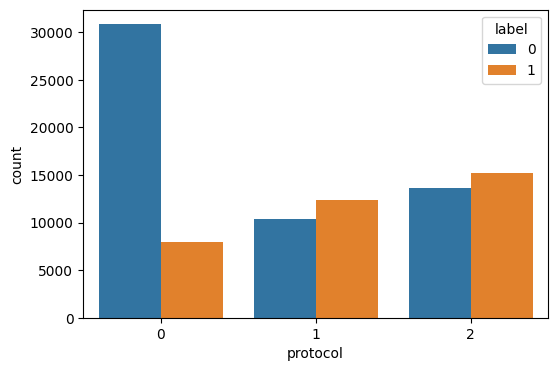

NameError: name 'protocol_mapping' is not defined

In [1]:
import ipynb
%run data.ipynb

In [2]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    IsolationForest
)

from sklearn import (
    metrics,
    preprocessing,
    metrics,
    svm
)

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler
)

from sklearn.feature_selection import (
    SelectKBest, 
    f_classif
)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import (
    layers, 
    models, 
    callbacks
)

from xgboost import XGBClassifier

In [3]:
#### Let's support which columns NUMERIC and which is OBJECT
df = data.copy()
df.columns = df.columns.str.strip().str.lower()
numeric_df = df.select_dtypes(include=['int64', 'float64'])
object_df = df.select_dtypes(include=['object'])
numeric_cols = numeric_df.columns
object_cols = object_df.columns
print('Numeric Columns: ')
print(numeric_cols, '\n')
print('Object Columns: ')
print(object_cols, '\n')
print('Number of Numeric Features: ', len(numeric_cols))
print('Number of Object Features: ', len(object_cols))

Numeric Columns: 
Index(['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps', 'label'],
      dtype='object') 

Object Columns: 
Index(['src', 'dst', 'protocol'], dtype='object') 

Number of Numeric Features:  20
Number of Object Features:  3


In [4]:
def process_data(df, numeric_cols):
    X = df[numeric_cols]
    y = df['label']
    
    # 1. Split with stratify to keep class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 2. Apply SMOTE on training data only
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # 3. Feature selection on resampled train data
    selector = SelectKBest(f_classif, k=10)
    X_train_selected = selector.fit_transform(X_train_res, y_train_res)
    X_test_selected = selector.transform(X_test)  # use same features
    
    # 4. Scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    return X_train_scaled, X_test_scaled, y_train_res, y_test


In [5]:
class Model:
    def __init__(self, X, y):
        self.data = X
        self.labels = y
        self.results = {}

        X_scaled = StandardScaler().fit_transform(X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_scaled, y, random_state=42, test_size=0.3, stratify=y
        )

    def LogisticRegression(self):
        print("\n=== Logistic Regression ===")
        solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        best_accuracy = 0
        best_solver = ''
        start_time = time.time()

        for solver in solvers:
            try:
                model = LogisticRegression(C=0.03, solver=solver, max_iter=1000)
                model.fit(self.X_train, self.y_train)
                y_pred = model.predict(self.X_test)
                acc = accuracy_score(self.y_test, y_pred)
                print(f"Solver: {solver}, Accuracy: {acc:.4f}")
                if acc > best_accuracy:
                    best_accuracy = acc
                    best_solver = solver
            except Exception as e:
                print(f"Solver {solver} failed: {e}")

        print(f"\nBest Solver: {best_solver} with Accuracy: {best_accuracy:.4f}")
        model = LogisticRegression(C=0.03, solver=best_solver, max_iter=1000)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["Logistic Regression"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def SupportVectorMachine(self):
        print("\n=== SVM ===")
        kernels = ['linear', 'poly', 'rbf', 'sigmoid']
        best_accuracy = 0
        best_kernel = ''
        start_time = time.time()

        for kernel in kernels:
            model = svm.SVC(kernel=kernel)
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            acc = accuracy_score(self.y_test, y_pred)
            print(f"Kernel: {kernel}, Accuracy: {acc:.4f}")
            if acc > best_accuracy:
                best_accuracy = acc
                best_kernel = kernel

        print(f"\nBest Kernel: {best_kernel} with Accuracy: {best_accuracy:.4f}")
        model = svm.SVC(kernel=best_kernel)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["SVM"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def KNearestNeighbor(self):
        print("\n=== K-Nearest Neighbors ===")
        start_time = time.time()
        accuracies = []
        Ks = 12

        for k in range(1, Ks):
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            acc = accuracy_score(self.y_test, y_pred)
            accuracies.append(acc)

        best_k = np.argmax(accuracies) + 1
        print(f"Best K: {best_k} with Accuracy: {accuracies[best_k-1]:.4f}")

        model = KNeighborsClassifier(n_neighbors=best_k)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["Kth Nearest"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def DecisionTree(self):
        print("\n=== Decision Tree ===")
        start_time = time.time()

        tree = DecisionTreeClassifier()
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': list(range(2, 11)),
            'max_leaf_nodes': list(range(2, 12))
        }

        grid = GridSearchCV(tree, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=0)
        grid.fit(self.X_train, self.y_train)

        print("Best Params:", grid.best_params_)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(self.X_test)

        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["Decision Tree"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def RandomForest(self):
        print("\n=== Random Forest ===")
        start_time = time.time()

        model = RandomForestClassifier(
            criterion='gini',
            n_estimators=500,
            min_samples_split=10,
            max_features='sqrt',
            oob_score=True,
            random_state=1,
            n_jobs=-1
        )
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)

        print(f"Accuracy: {accuracy_score(self.y_test, y_pred):.4f}")
        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["Random Forest"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def autoencoder_iforest(self):
        print("\n=== AutoEncoder + Isolation Forest ===")
        start_time = time.time()

        input_dim = self.X_train.shape[1]
        encoding_dim = 32

        input_layer = layers.Input(shape=(input_dim,))
        encoded = layers.Dense(64, activation='relu')(input_layer)
        encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

        autoencoder = models.Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(self.X_train, self.X_train,
                        epochs=50,
                        batch_size=32,
                        shuffle=True,
                        validation_data=(self.X_test, self.X_test),
                        verbose=0)

        encoder = models.Model(input_layer, encoded)
        X_train_encoded = encoder.predict(self.X_train)
        X_test_encoded = encoder.predict(self.X_test)

        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        iso_forest.fit(X_train_encoded)
        y_pred = iso_forest.predict(X_test_encoded)
        y_pred_binary = (y_pred == -1).astype(int)

        print(classification_report(self.y_test, y_pred_binary))
        auc = metrics.roc_auc_score(self.y_test, iso_forest.decision_function(X_test_encoded))
        print(f"AUC-ROC: {auc:.4f}")
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["Autoencoder + Isolation Forest"] = {
            "accuracy": accuracy_score(self.y_test, y_pred_binary),
            "precision": precision_score(self.y_test, y_pred_binary),
            "recall": recall_score(self.y_test, y_pred_binary),
            "f1": f1_score(self.y_test, y_pred_binary)
        }

        

    def xgboost(self):
        print("\n=== XGBoost ===")
        start_time = time.time()
        model = XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        y_proba = model.predict_proba(self.X_test)[:, 1]

        # Classification Report
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred))

        # ROC AUC
        roc_auc = roc_auc_score(self.y_test, y_proba)
        print("AUC-ROC:", round(roc_auc, 4))

        # Confusion Matrix
        # cm = confusion_matrix(self.y_test, y_pred)
        # plt.figure(figsize=(6, 4))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_proba)
        # plt.figure()
        # plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        # plt.plot([0, 1], [0, 1], 'k--')
        # plt.xlabel("False Positive Rate")
        # plt.ylabel("True Positive Rate")
        # plt.title("ROC Curve")
        # plt.legend()
        # plt.grid()
        # plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_proba)
        pr_auc = auc(recall, precision)
        # plt.figure()
        # plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})', color='purple')
        # plt.xlabel("Recall")
        # plt.ylabel("Precision")
        # plt.title("Precision-Recall Curve")
        # plt.legend()
        # plt.grid()
        # plt.show()

        #return model

        print(f"Accuracy: {accuracy_score(self.y_test, y_pred):.4f}")
        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["XGBoost"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def MLP(self, epochs=50, batch_size=64):
        print("\n=== MLP (Dense) ===")
        start_time = time.time()

        input_dim = self.X_train.shape[1]
        model = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(self.X_train, self.y_train, validation_split=0.1,
                            epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)

        y_proba = model.predict(self.X_test).ravel()
        y_pred = (y_proba > 0.5).astype(int)

        print(classification_report(self.y_test, y_pred))
        self.results["MLP"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred, zero_division=0),
            "recall": recall_score(self.y_test, y_pred, zero_division=0),
            "f1": f1_score(self.y_test, y_pred, zero_division=0)
        }
        print("--- %s seconds ---" % (time.time() - start_time))
        return model, history

    def LSTM(self, epochs=50, batch_size=64, timesteps=1):
        """
        LSTM expects 3D input: (samples, timesteps, features).
        If your data is NOT windowed, use timesteps=1 (default). For sequence data,
        prepare X as windows and set timesteps accordingly.
        """
        print("\n=== LSTM ===")
        start_time = time.time()

        n_features = self.X_train.shape[1]
        # reshape to (samples, timesteps, features)
        X_train_seq = self.X_train.reshape((self.X_train.shape[0], timesteps, n_features))
        X_test_seq = self.X_test.reshape((self.X_test.shape[0], timesteps, n_features))

        model = models.Sequential([
            layers.Input(shape=(timesteps, n_features)),
            layers.LSTM(64, return_sequences=False),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(X_train_seq, self.y_train, validation_split=0.1, epochs=epochs,
                            batch_size=batch_size, callbacks=[es], verbose=0)

        y_proba = model.predict(X_test_seq).ravel()
        y_pred = (y_proba > 0.5).astype(int)

        print(classification_report(self.y_test, y_pred))
        self.results["LSTM"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred, zero_division=0),
            "recall": recall_score(self.y_test, y_pred, zero_division=0),
            "f1": f1_score(self.y_test, y_pred, zero_division=0)
        }
        print("--- %s seconds ---" % (time.time() - start_time))
        return model, history

    def GRU(self, epochs=50, batch_size=64, timesteps=1):
        """
        Similar to LSTM but using GRU layers.
        """
        print("\n=== GRU ===")
        start_time = time.time()

        n_features = self.X_train.shape[1]
        X_train_seq = self.X_train.reshape((self.X_train.shape[0], timesteps, n_features))
        X_test_seq = self.X_test.reshape((self.X_test.shape[0], timesteps, n_features))

        model = models.Sequential([
            layers.Input(shape=(timesteps, n_features)),
            layers.GRU(64, return_sequences=False),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(X_train_seq, self.y_train, validation_split=0.1, epochs=epochs,
                            batch_size=batch_size, callbacks=[es], verbose=0)

        y_proba = model.predict(X_test_seq).ravel()
        y_pred = (y_proba > 0.5).astype(int)

        print(classification_report(self.y_test, y_pred))
        self.results["GRU"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred, zero_division=0),
            "recall": recall_score(self.y_test, y_pred, zero_division=0),
            "f1": f1_score(self.y_test, y_pred, zero_division=0)
        }
        print("--- %s seconds ---" % (time.time() - start_time))
        return model, history

    def Conv1D(self, epochs=50, batch_size=64):
        """
        1D-CNN for tabular data: we reshape to (samples, features, 1) and apply Conv1D.
        """
        print("\n=== 1D-CNN ===")
        start_time = time.time()

        n_features = self.X_train.shape[1]
        # reshape to (samples, timesteps=n_features, channels=1)
        X_train_cnn = self.X_train.reshape((self.X_train.shape[0], n_features, 1))
        X_test_cnn = self.X_test.reshape((self.X_test.shape[0], n_features, 1))

        model = models.Sequential([
            layers.Input(shape=(n_features, 1)),
            layers.Conv1D(64, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(32, kernel_size=3, activation='relu'),
            layers.GlobalMaxPooling1D(),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(X_train_cnn, self.y_train, validation_split=0.1,
                            epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)

        y_proba = model.predict(X_test_cnn).ravel()
        y_pred = (y_proba > 0.5).astype(int)

        print(classification_report(self.y_test, y_pred))
        self.results["1D-CNN"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred, zero_division=0),
            "recall": recall_score(self.y_test, y_pred, zero_division=0),
            "f1": f1_score(self.y_test, y_pred, zero_division=0)
        }
        print("--- %s seconds ---" % (time.time() - start_time))
        return model, history

    def plot_results(self, metric="accuracy"):
        """
        Plots bar chart comparing models on a selected metric.
        Metric can be: 'accuracy', 'precision', 'recall', or 'f1'
        """
        if not self.results:
            print("No results to plot. Run some models first.")
            return
        
        valid_metrics = ["accuracy", "precision", "recall", "f1"]
        if metric not in valid_metrics:
            raise ValueError(f"Invalid metric. Choose from {valid_metrics}")

        model_names = list(self.results.keys())
        values = [self.results[model][metric] for model in model_names]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=model_names, y=values, palette="Set2")
        plt.title(f"Model Comparison on {metric.capitalize()}")
        plt.ylabel(metric.capitalize())
        plt.xlabel("Model")
        plt.ylim(0, 1.05)
        plt.xticks(rotation=30)
        for i, v in enumerate(values):
            plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()




In [6]:
df = df.dropna()
X = df.drop(['dt','src','dst','label'], axis=1)
y = df.label

In [7]:
X = pd.get_dummies(X)

In [8]:
model = Model(X, y)

In [14]:
model.LogisticRegression()


=== Logistic Regression ===
Solver: newton-cg, Accuracy: 0.7621
Solver: lbfgs, Accuracy: 0.7621
Solver: liblinear, Accuracy: 0.7620
Solver: sag, Accuracy: 0.7621
Solver: saga, Accuracy: 0.7621

Best Solver: newton-cg with Accuracy: 0.7621
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     19001
           1       0.71      0.66      0.68     12151

    accuracy                           0.76     31152
   macro avg       0.75      0.74      0.75     31152
weighted avg       0.76      0.76      0.76     31152

--- 1.5605628490447998 seconds ---


In [15]:
model.SupportVectorMachine()


=== SVM ===
Kernel: linear, Accuracy: 0.7800
Kernel: poly, Accuracy: 0.9665
Kernel: rbf, Accuracy: 0.9676
Kernel: sigmoid, Accuracy: 0.5670

Best Kernel: rbf with Accuracy: 0.9676
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     19001
           1       0.95      0.97      0.96     12151

    accuracy                           0.97     31152
   macro avg       0.96      0.97      0.97     31152
weighted avg       0.97      0.97      0.97     31152

--- 348.8785619735718 seconds ---


In [16]:
model.KNearestNeighbor()


=== K-Nearest Neighbors ===
Best K: 1 with Accuracy: 0.9777
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19001
           1       0.97      0.97      0.97     12151

    accuracy                           0.98     31152
   macro avg       0.98      0.98      0.98     31152
weighted avg       0.98      0.98      0.98     31152

--- 12.354860067367554 seconds ---


In [17]:
model.DecisionTree()


=== Decision Tree ===
Best Params: {'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 11}
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19001
           1       0.97      0.99      0.98     12151

    accuracy                           0.98     31152
   macro avg       0.98      0.98      0.98     31152
weighted avg       0.98      0.98      0.98     31152

--- 16.11447501182556 seconds ---


In [18]:
model.RandomForest()


=== Random Forest ===
Accuracy: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19001
           1       1.00      1.00      1.00     12151

    accuracy                           1.00     31152
   macro avg       1.00      1.00      1.00     31152
weighted avg       1.00      1.00      1.00     31152

--- 6.559780836105347 seconds ---


In [ ]:
model.autoencoder_iforest()


=== AutoEncoder + Isolation Forest ===


In [ ]:
model.xgboost()

In [ ]:
model.MLP()

In [ ]:
model.LSTM(timesteps=1)  

In [ ]:
model.GRU(timesteps=1)

In [ ]:
model.Conv1D()

In [ ]:
model.plot_results("accuracy")
model.plot_results("f1")